<a href="https://colab.research.google.com/github/Farhad-Davaripour/AI_Applications_in_Pipeline_Engineering/blob/main/demo.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>


# **AI in Pipeline Engineering**

# Summary

This notebook centers on predicting the maximum depth of anomalies in In-Line Inspection (ILI) data. Utilizing various machine learning techniques, the goal is to fill in missing values and forecast the future growth of anomalies. Accurately estimating anomaly depth is critical for assessing pipeline strength and ensuring safety. The process involves data exploration, cleaning, feature engineering, anomaly mapping, and advanced modeling. These steps offer valuable insights for managing pipeline integrity, enabling proactive maintenance and risk mitigation.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models", was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# 1. Introduction

Pipeline integrity management is crucial in ensuring the safety and reliability of gas and oil transportation. In-line inspection (ILI) tools are extensively used to detect and measure anomalies in pipelines. Accurately predicting the maximum depth of these anomalies is essential for proactive maintenance and risk mitigation. This notebook demonstrates a comprehensive workflow, from data loading and cleaning to advanced machine learning modeling, aimed at predicting anomaly depths effectively. Key steps in the process include:

**Data Exploration and Cleaning**: This involves exploratory data analysis (EDA) to understand the data distribution and identify patterns, handling duplicate records, and managing missing values.

**Feature Engineering**: We compute new features such as aspect ratio and area of anomalies, estimate the maximum depth using domain-specific calculations, and create cyclic features from angular measurements.

**Anomaly Mapping**: We match anomalies across different inspection years to track their growth and changes over time. This involves sophisticated matching algorithms to identify corresponding anomalies based on relative distances and orientations.

**Modeling**: We employ machine learning models, particularly the Hist Gradient Boosting Regressor, to predict the maximum depth of anomalies. This includes data preparation, model training, hyperparameter tuning, and evaluation.

**Prediction and Validation**: The predicted values are validated against actual measurements to ensure accuracy. We also compare the machine learning predictions with domain-specific estimates to highlight the added value of advanced modeling techniques.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models," was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# 2. Setup

**Import Dependencies**

In [1]:
# Install necessary packages
!pip install imbalanced-learn
!pip install scikit-optimize
!pip install wget
!pip install openai
!pip install python-dotenv

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from imblearn.under_sampling import RandomUnderSampler
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt.callbacks import DeltaYStopper
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
import wget

c:\Users\Farhad.Davaripour\Repositories\AI_Applications_in_Pipeline_Engineering\.venv\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import wget
import importlib

# Step 1: Ensure the src directory exists
src_directory = 'src'
if not os.path.exists(src_directory):
    os.makedirs(src_directory)
    print(f"Directory '{src_directory}' created.")

# Step 2: Define the path for the tools.py file
tools_path = os.path.join(src_directory, 'tools.py')

# Step 3: Remove the existing 'tools.py' file if it exists
if os.path.exists(tools_path):
    os.remove(tools_path)
    print("Existing 'tools.py' file removed.")

# Step 4: Download the 'tools.py' file from GitHub into the src directory
url = 'https://raw.githubusercontent.com/Farhad-Davaripour/AI_Applications_in_Pipeline_Engineering/main/src/tools.py'
wget.download(url, tools_path)

# Step 5: Import tools module from src directory
import sys
sys.path.insert(0, src_directory)  # Ensure the directory is in Python's path
import tools

# Step 6: Optionally reload if necessary
importlib.reload(tools)

Existing 'tools.py' file removed.


<module 'tools' from 'c:\\Users\\Farhad.Davaripour\\Repositories\\AI_Applications_in_Pipeline_Engineering\\src\\tools.py'>

In [7]:
from openai import OpenAI

# from dotenv import load_dotenv
# _ = load_dotenv(override=True)
# client = OpenAI()

from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key = OPENAI_API_KEY)

In [8]:
def ask_me(user_query):
    messages = [{"role": "system", "content": "You are an AI assistant that answers to the user query."},
                {"role": "user", "content": user_query}
                ]
    completion = client.chat.completions.create(
                model='gpt-4o-mini',
                temperature=0,
                messages=messages)
    return completion.choices[0].message.content

user_query = 'Provide concise description of International Pipeline Conference (IPC) conference in Calgary? keep it in under 20 words.'
print(ask_me(user_query))


The International Pipeline Conference (IPC) in Calgary focuses on pipeline engineering, technology, and management, fostering global collaboration.


**Loading the ILI Data**

In [9]:
# Load the data locally - Set the directory to save and read the data
# save_path = "Dataset/processed_data/"
# Anomalies_df  = pd.read_parquet(os.path.join(save_path, f'Anomoly_processed.parquet'))

In [10]:
# URL of the raw Parquet file from GitHub
url = 'https://github.com/Farhad-Davaripour/AI_Applications_in_Pipeline_Engineering/raw/main/Dataset/processed_data/Anomoly_processed.parquet'

# Use pandas with fsspec to read the Parquet file directly
Anomalies_df = pd.read_parquet(url, engine='pyarrow', storage_options={"anon": True})

**Rename Columns**

In [11]:
from tools import rename_anomaly_columns

# Rename the columns to make them more readable
Anomalies_df = rename_anomaly_columns(Anomalies_df)

In [12]:
i = 0
for col in Anomalies_df.columns:
    print(f"column #{i+1}: {col}")
    i+=1

column #1: InspectionYear
column #2: GirthWeldNumber
column #3: JointLength_m
column #4: RelativeDistance_m
column #5: SeamOrientation_deg
column #6: StartPointDistance_m
column #7: StartPointOrientation_deg
column #8: EndPointDistance_m
column #9: EndPointOrientation_deg
column #10: SignificantPointRelDistance_m
column #11: SignificantPointOrientation_deg
column #12: WallThickness_mm
column #13: FeatureLength_mm
column #14: FeatureWidth_mm
column #15: MaxDepth_mm


# 3. EDA

In [13]:
from tools import EDA

**Max Depth (mm)**

In [14]:
# Create the EDA object
eda = EDA(Anomalies_df)

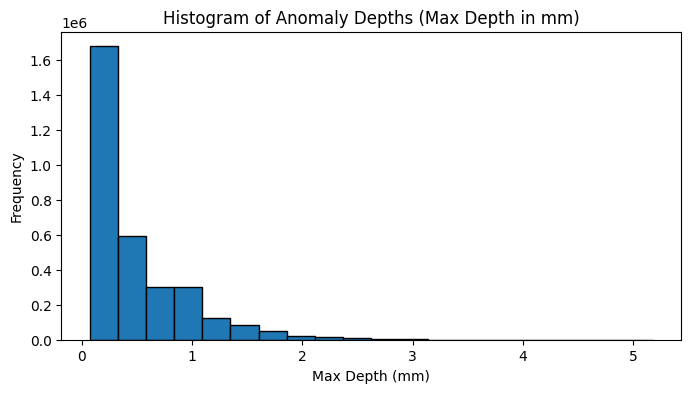

In [15]:
# plot the histogram of the max depth
eda.plot_histogram_max_depth('MaxDepth_mm')

In [16]:
# Summary statistics
Anomalies_df['MaxDepth_mm'].describe()

count    3.198420e+06
mean     4.612879e-01
std      4.766933e-01
min      7.000000e-02
25%      7.000000e-02
50%      2.800000e-01
75%      7.100000e-01
max      5.180000e+00
Name: MaxDepth_mm, dtype: float64

In [17]:
# Calculate the percentiles and IQR
eda.calculate_percentiles_and_iqr('MaxDepth_mm')

25th Percentile (Q1): 0.07
50th Percentile (Q2): 0.28
75th Percentile (Q3): 0.71
Interquartile Range (IQR): 0.64
Lower Bound: 0
Upper Bound: 1.67


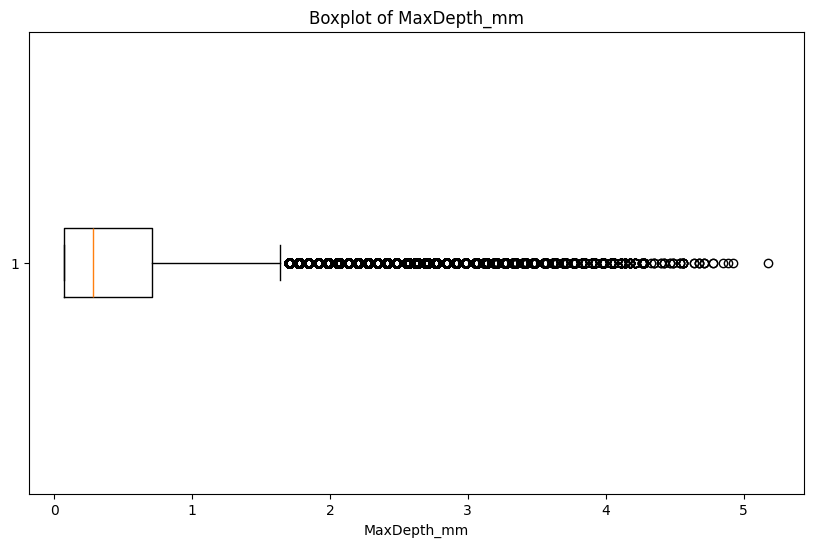

In [18]:
# Plot the boxplot
eda.plot_boxplot_max_depth('MaxDepth_mm')

**Linear Correlation**

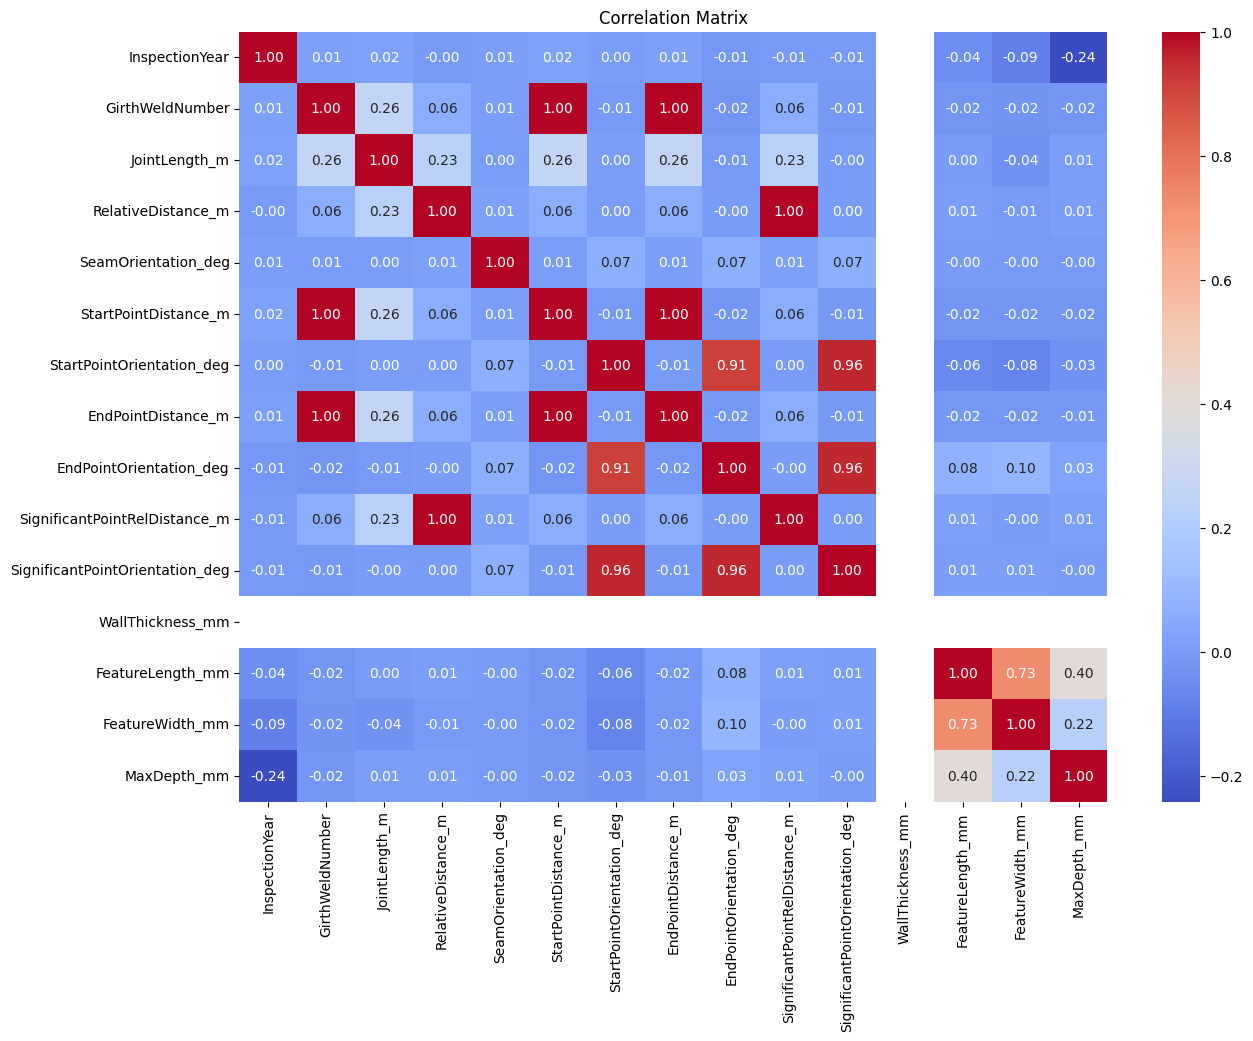

In [19]:
eda.plot_correlation_matrix()

# 4. Data Preprocessing

## 4.1 Fix Data Types

In [20]:
Anomalies_df.dtypes

InspectionYear                     category
GirthWeldNumber                    category
JointLength_m                       float64
RelativeDistance_m                  float64
SeamOrientation_deg                 float64
StartPointDistance_m                float64
StartPointOrientation_deg           float64
EndPointDistance_m                  float64
EndPointOrientation_deg             float64
SignificantPointRelDistance_m       float64
SignificantPointOrientation_deg     float64
WallThickness_mm                   category
FeatureLength_mm                    float64
FeatureWidth_mm                     float64
MaxDepth_mm                         float64
dtype: object

In [21]:
Anomalies_df['InspectionYear'] = Anomalies_df['InspectionYear'].astype(int)
Anomalies_df['GirthWeldNumber'] = Anomalies_df['GirthWeldNumber'].astype(int)
Anomalies_df['WallThickness_mm'] = Anomalies_df['WallThickness_mm'].astype(float)

In [22]:
Anomalies_df.dtypes

InspectionYear                       int32
GirthWeldNumber                      int32
JointLength_m                      float64
RelativeDistance_m                 float64
SeamOrientation_deg                float64
StartPointDistance_m               float64
StartPointOrientation_deg          float64
EndPointDistance_m                 float64
EndPointOrientation_deg            float64
SignificantPointRelDistance_m      float64
SignificantPointOrientation_deg    float64
WallThickness_mm                   float64
FeatureLength_mm                   float64
FeatureWidth_mm                    float64
MaxDepth_mm                        float64
dtype: object

## 4.2 Duplicate Values

In [23]:
# Check for duplicate rows
duplicates = Anomalies_df.duplicated(keep=False)

# Display the duplicate rows
duplicate_rows = Anomalies_df[duplicates]

# Print the duplicate rows
print("Duplicate rows in the dataframe:")
print(duplicate_rows)

Duplicate rows in the dataframe:
Empty DataFrame
Columns: [InspectionYear, GirthWeldNumber, JointLength_m, RelativeDistance_m, SeamOrientation_deg, StartPointDistance_m, StartPointOrientation_deg, EndPointDistance_m, EndPointOrientation_deg, SignificantPointRelDistance_m, SignificantPointOrientation_deg, WallThickness_mm, FeatureLength_mm, FeatureWidth_mm, MaxDepth_mm]
Index: []


## 4.3 Missing Values

In [24]:
from tools import MissingValuesAnalyzer

# Create the MissingValuesAnalyzer object
MissingValuesAnalyzer = MissingValuesAnalyzer(Anomalies_df)

**Identify Features w/ Missing Values**

In [25]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 845310
EndPointDistance_m: 759683


### 4.3.1 End Point Distance                 

In [26]:
# Apply the calculation only if the 'EndPointDistance_m' column has NaN values
Anomalies_df['EndPointDistance_m'] = np.where(
    Anomalies_df['EndPointDistance_m'].isna(),
    Anomalies_df['StartPointDistance_m'] + Anomalies_df['FeatureLength_mm'] / 1000,
    Anomalies_df['EndPointDistance_m']
)

In [27]:
# Find the remaining columns with missing values
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 845310


### 4.3.2 Seam Orientation             

#### 4.3.2.1 Handle Joints with Inconsistent Seam Orientation**

In [28]:
# Handle joints with inconsistent seam orientation and print only the last joint
MissingValuesAnalyzer.check_inconsistent_seam_orientation()

The last inconsistent joint's details:
 
GirthWeldNumber 18571:
  InspectionYear 1:
SeamOrientation_deg
56.0    98
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
62.0    106
  InspectionYear 7:
SeamOrientation_deg
62.0    104



In [29]:
# Handle joints with inconsistent seam orientation
Anomalies_df = MissingValuesAnalyzer.handle_inconsistent_seam_orientation()

In [30]:
# Find and report the inconsistent joints
MissingValuesAnalyzer.find_and_report_inconsistent_joints()

All joints have consistent seam orientations.


#### 4.3.2.2 Handle Joints with missing Values

**Permutation using Mean**

In [31]:
# Fill the missing seam orientation values with the average. Since each joints has a unique seam orientation, the average is the same as the original value.
Anomalies_df, filled = MissingValuesAnalyzer.fill_missing_seam_orientation_w_average()
print(f"number of filled values: {filled}")

number of filled values: 802450


In [32]:
# Find columns with missing values. The remaining missing values occurs in joints with no seam orientation across all inspection years. For those, we can use fill forward from the previous joint.
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 15747


**Permutation using Fill Forward**

In [33]:
# Fill the missing seam orientation values with the previous value
AnomaliesProc =  MissingValuesAnalyzer.fill_missing_seam_orientation_w_ffill()

In [34]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

No missing values found in 'SeamOrientation_deg' column.


## 4.4 Outlier Removal

In [82]:
from tools import HandlingOutlier

# Example usage
handling_outlier_columns = ['MaxDepth_mm', 'FeatureWidth_mm', 'FeatureLength_mm']

# Create an instance of the HandlingOutlier class
outlier_handler = HandlingOutlier(AnomaliesProc)

# Remove outliers using Z-score method
Anomalies_OutliersAdjusted_df = outlier_handler.remove_outliers_zscore(handling_outlier_columns)

# Remove outliers using Isolation Forest method
Anomalies_OutliersAdjusted_df = outlier_handler.remove_outliers_isolation_forest(handling_outlier_columns)

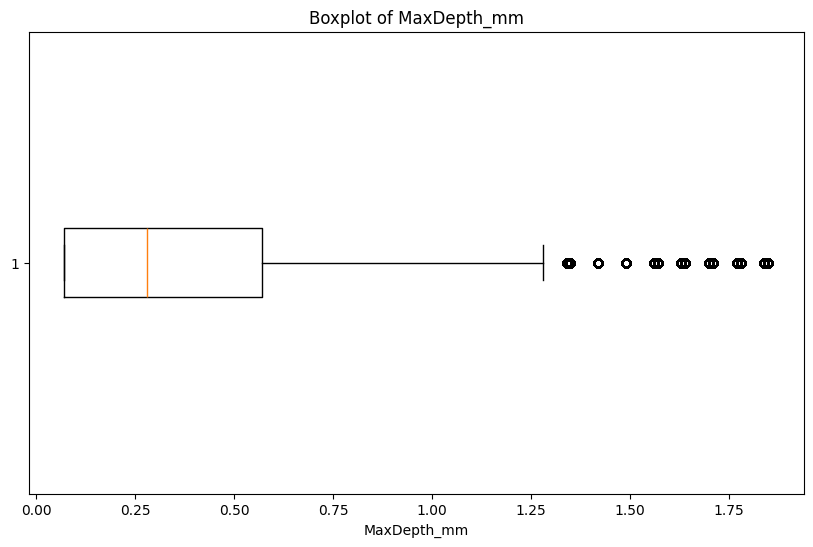

In [83]:
# Create the EDA object
eda = EDA(Anomalies_OutliersAdjusted_df)

# Plot the boxplot
eda.plot_boxplot_max_depth('MaxDepth_mm')

# 5. Feature Engineering

**Predicting Anomaly Depth: A Machine Learning Approach**
This exercise aims to predict the maximum depth of anomalies for educational purposes. The applications of this prediction include filling in missing data and forecasting the future growth of anomalies, particularly the maximum depth.

## 5.1 Setup

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt.callbacks import DeltaYStopper

In [85]:
# Make a copy of the DataFrame
Anomalies_EngineeringFeatures_df = Anomalies_OutliersAdjusted_df.copy()

## 5.2 Anomaly Mapping

**Setup**

In [86]:
from tools import Anomaly_mapping, plot_anomalies_by_year

# Define the parameters
increment_size = 1000
relative_distance_threshold = 0.1  # meters
orientation_threshold = 10  # degrees

**Running the Mapping Pipeline**

In [87]:
# Create an instance of Anomaly_mapping using AnomaliesProc_ML_Ready
# anomaly_mapper = Anomaly_mapping(Anomalies_EngineeringFeatures_df, relative_distance_threshold, orientation_threshold)

# # Call the process_in_increments method and store the result in Anomalies_EngineeringFeatures_Mapped_df
# anomaly_mapper.process_in_increments(save_path, increment_size)

In [88]:
# Anomalies_EngineeringFeatures_Mapped_df = anomaly_mapper.concat_mapped_dfs(save_path)

In [89]:
# Save the updated DataFrame to a CSV file
# Plot_Anomaly_mapped_df_file_path = (os.path.join(save_path, f'Plot_Mapped_Anomalies.csv'))

# Anomalies_EngineeringFeatures_Mapped_df[[ # type: ignore
#     'GirthWeldNumber',
#     'InspectionYear',
#     'RelativeDistance_m',
#     'Tag',
#     'SignificantPointOrientation_deg'
# ]].to_parquet(Plot_Anomaly_mapped_df_file_path, index=False)

**Plot the anomalies by year**

In [90]:
# Load the data locally
# Anomalies_EngineeringFeatures_Mapped_df = pd.read_parquet(os.path.join(save_path, 'Anomalies_Mapped_First_1000_GirthWelds.parquet'))

# Load the data from github url
url = 'https://github.com/Farhad-Davaripour/AI_Applications_in_Pipeline_Engineering/raw/main/Dataset/processed_data/Anomalies_Mapped_First_1000_GirthWelds.parquet'

# Use pandas with fsspec to read the Parquet file directly
Anomalies_EngineeringFeatures_Mapped_df = pd.read_parquet(url, engine='pyarrow', storage_options={"anon": True})

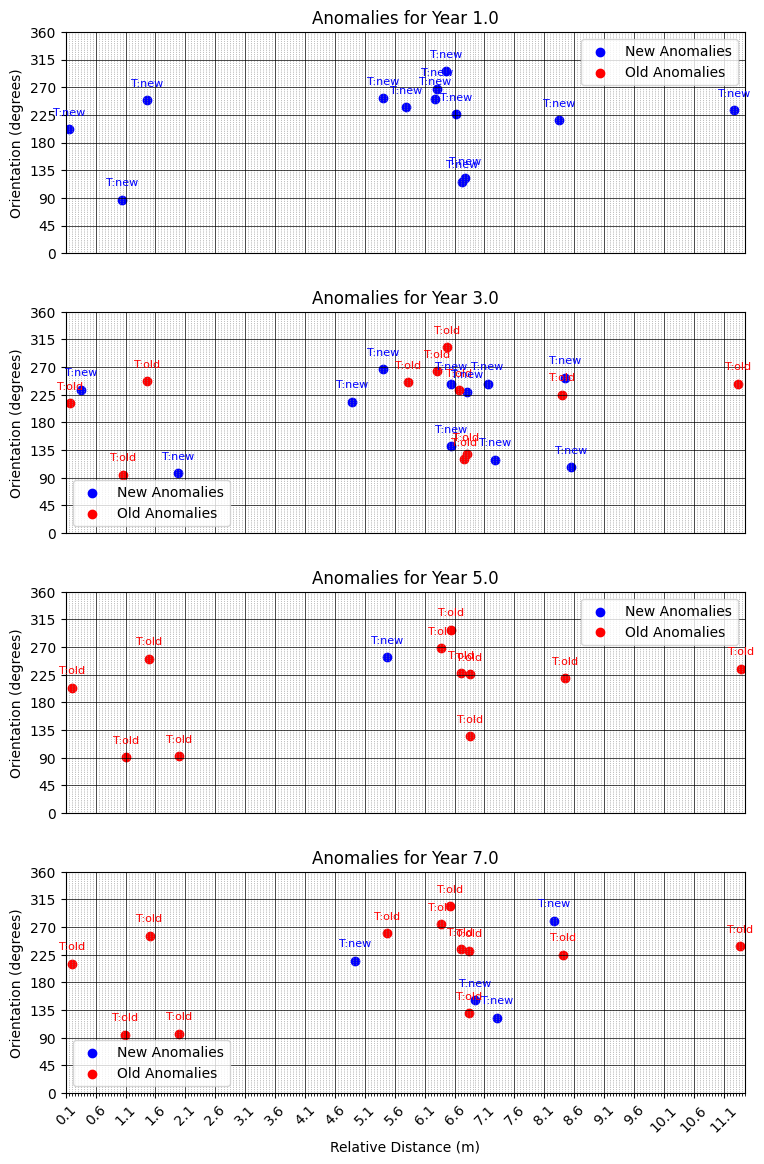

In [91]:
# Plot the anomalies by year
plot_anomalies_by_year(Anomalies_EngineeringFeatures_Mapped_df, 14, figsize=(8, 3)) # type: ignore

## 5.4 Aspect Ratio and Area

In [92]:
from tools import FeatureEngineering

# Create an instance of the class with your dataframe
feature_engineering = FeatureEngineering(Anomalies_EngineeringFeatures_Mapped_df)

In [93]:
# Compute the aspect ratio
Anomalies_EngineeringFeatures_Geometric_df = feature_engineering.compute_aspect_ratio()

# Calculate the feature area
Anomalies_EngineeringFeatures_Geometric_df = feature_engineering.calculate_feature_area()

In [94]:
# Selecting columns
selected_columns = ['FeatureLength_mm', 'FeatureWidth_mm', 'AspectRatio', 'FeatureArea_mm2',]

# Creating a new DataFrame with only the selected columns
Anomalies_EngineeringFeatures_Geometric_df[selected_columns].head()

,FeatureLength_mm,FeatureWidth_mm,AspectRatio,FeatureArea_mm2
0,15.0,28.0,0.535714,329.867229
1,41.0,102.0,0.401961,3284.535119
2,32.0,92.0,0.347826,2312.212193
3,26.0,167.0,0.155689,3410.198825
4,44.0,100.0,0.440000,3455.751919


## 5.5 Radial to Cyclic Features

In [95]:
# Add the angular features
angle_columns = ['SignificantPointOrientation_deg']
Anomalies_EngineeringFeatures_Radial2Cyclic_df = feature_engineering.add_angular_features(angle_columns)

In [96]:
# Selecting columns that end with '_rad'
rad_columns = [col for col in Anomalies_EngineeringFeatures_Radial2Cyclic_df.columns if col.startswith('SignificantPointOrientation')]
# Creating a new DataFrame with only the selected columns
Anomalies_EngineeringFeatures_Radial2Cyclic_df[rad_columns].head()

,SignificantPointOrientation_deg,SignificantPointOrientation_deg_rad,SignificantPointOrientation_deg_sin,SignificantPointOrientation_deg_cos
0,202.0,3.525565,-0.374607,-0.927184
1,87.0,1.518436,0.998630,0.052336
2,249.0,4.345870,-0.933580,-0.358368
3,252.0,4.398230,-0.951057,-0.309017
4,237.0,4.136430,-0.838671,-0.544639


## 5.6 Tag Erroneous Records

In [97]:
from tools import ErroneousAnomalyProcessor

# Detect errors in mapped anomalies
anomaly_processor = ErroneousAnomalyProcessor(Anomalies_EngineeringFeatures_Radial2Cyclic_df)

# Apply the detect_errors method
Anomalies_EngineeringFeatures_Tagging_df = Anomalies_EngineeringFeatures_Radial2Cyclic_df.copy()
Anomalies_EngineeringFeatures_Tagging_df['ErrorClassification'] = Anomalies_EngineeringFeatures_Tagging_df.apply(
    anomaly_processor.detect_errors, axis=1
)

In [98]:
anomaly_processor = ErroneousAnomalyProcessor(Anomalies_EngineeringFeatures_Tagging_df)

# Print anomaly statistics
anomaly_processor.print_error_statistics()

number of erroneous records: 7100
number of correct records:  25506
percentage of erroneous records: 21.78%

number of old records: 18727
number of new records: 13879
percentage of old records: 57.43%


## 5.7 Include Second Prior Inspection Data

In [99]:
from tools import add_dprev_features

# Add the secont previous inspection year features to the DataFrame
Old_Anomalies_EngineeringFeatures_Dprev_df = add_dprev_features(Anomalies_EngineeringFeatures_Tagging_df)

Processed 1 / 32606 rows
Processed 1001 / 32606 rows
Processed 2001 / 32606 rows
Processed 3001 / 32606 rows
Processed 4001 / 32606 rows
Processed 5001 / 32606 rows
Processed 6001 / 32606 rows
Processed 7001 / 32606 rows
Processed 8001 / 32606 rows
Processed 9001 / 32606 rows
Processed 10001 / 32606 rows
Processed 11001 / 32606 rows
Processed 12001 / 32606 rows
Processed 13001 / 32606 rows
Processed 14001 / 32606 rows
Processed 15001 / 32606 rows
Processed 16001 / 32606 rows
Processed 17001 / 32606 rows
Processed 18001 / 32606 rows
Processed 19001 / 32606 rows
Processed 20001 / 32606 rows
Processed 21001 / 32606 rows
Processed 22001 / 32606 rows
Processed 23001 / 32606 rows
Processed 24001 / 32606 rows
Processed 25001 / 32606 rows
Processed 26001 / 32606 rows
Processed 27001 / 32606 rows
Processed 28001 / 32606 rows
Processed 29001 / 32606 rows
Processed 30001 / 32606 rows
Processed 31001 / 32606 rows
Processed 32001 / 32606 rows
Processed 32606 / 32606 rows


In [100]:
# Load the data locally
# Old_Anomalies_EngineeringFeatures_Dprev_df = pd.read_parquet(os.path.join(save_path, 'Old_Anomalies_EngineeringFeatures_Dprev.parquet'))

# Load from github url
url = 'https://github.com/Farhad-Davaripour/AI_Applications_in_Pipeline_Engineering/raw/main/Dataset/processed_data/Old_Anomalies_EngineeringFeatures_Dprev.parquet'

# Use pandas with fsspec to read the Parquet file directly
Old_Anomalies_EngineeringFeatures_Dprev_df = pd.read_parquet(url, engine='pyarrow', storage_options={"anon": True})

## 5.8 Filter Anomalies
This section should ideally be moved from Feature Engineering to Data Pre-processing step. However, the next step of including data from the second prior inspection is computationally intensive. The curation process in this step will reduce the data population, thereby decreasing computational latency.

In [101]:
# Filter the DataFrame to include only the 'Okay' records
Anomalies_EngineeringFeatures_Filtered_df = Old_Anomalies_EngineeringFeatures_Dprev_df[Old_Anomalies_EngineeringFeatures_Dprev_df.ErrorClassification == 'Okay']

# Filter the DataFrame to include only the 'old' and 'new' records
Old_Anomalies_EngineeringFeatures_Filtered_df = Anomalies_EngineeringFeatures_Filtered_df[Anomalies_EngineeringFeatures_Filtered_df.Tag == 'old']
New_Anomalies_EngineeringFeatures_Filtered_df = Anomalies_EngineeringFeatures_Filtered_df[Anomalies_EngineeringFeatures_Filtered_df.Tag == 'new']

# Remove null values
Old_Anomalies_EngineeringFeatures_Filtered_df.dropna(inplace=True)

## 5.9 Estimated Anomaly Geometry

In [102]:
Old_Anomalies_EngineeringFeatures_EstGeometry_df = Old_Anomalies_EngineeringFeatures_Filtered_df.copy()

Old_Anomalies_EngineeringFeatures_EstGeometry_df['Estimated_FeatureLength_mm'] = (
    2 * Old_Anomalies_EngineeringFeatures_EstGeometry_df['Prev_FeatureLength_mm'] -
    Old_Anomalies_EngineeringFeatures_EstGeometry_df['DPrev_FeatureLength_mm']
)

Old_Anomalies_EngineeringFeatures_EstGeometry_df['Estimated_FeatureWidth_mm'] = (
    2 * Old_Anomalies_EngineeringFeatures_EstGeometry_df['Prev_FeatureWidth_mm'] -
    Old_Anomalies_EngineeringFeatures_EstGeometry_df['DPrev_FeatureWidth_mm']
)

Old_Anomalies_EngineeringFeatures_EstGeometry_df['Powered_Prev_MaxDepth_mm'] = (
    Old_Anomalies_EngineeringFeatures_EstGeometry_df['Prev_MaxDepth_mm'] ** 2
)

## 5.10 Encoding Anomaly Cluster

In [103]:
from tools import AnomalyClusterer

In [104]:
# List of features to be used for clustering
clustering_features = [
    'RelativeDistance_m',
    'FeatureLength_mm',
    'FeatureWidth_mm',
    'MaxDepth_mm',
    'SignificantPointOrientation_deg',
    'Prev_RelativeDistance_m',
    'Prev_FeatureLength_mm',
    'Prev_FeatureWidth_mm',
    'Prev_MaxDepth_mm',
    'Prev_SignificantPointOrientation_deg',
    'JointLength_m',
    'SeamOrientation_deg',
    'StartPointDistance_m',
    'StartPointOrientation_deg',
    'EndPointDistance_m',
    'EndPointOrientation_deg',
    'SignificantPointRelDistance_m',
    'WallThickness_mm',
    'AspectRatio',
    'FeatureArea_mm2']

In [105]:
# Create an instance of the AnomalyClusterer class
clusterer = AnomalyClusterer(Old_Anomalies_EngineeringFeatures_EstGeometry_df, clustering_features, 3)

In [106]:
# Perform clustering
Old_Anomalies_EngineeringFeatures_Clustered_df = clusterer.perform_clustering()

In [107]:
Old_Anomalies_EngineeringFeatures_Clustered_df[['GirthWeldNumber',
                                                'InspectionYear',
                                                'RelativeDistance_m',
                                                'SignificantPointOrientation_deg',
                                                'anomaly_type']
                                                ].head()

,GirthWeldNumber,InspectionYear,RelativeDistance_m,SignificantPointOrientation_deg,anomaly_type
6,14.0,5.0,6.54,298.0,2
11,14.0,7.0,6.53,304.0,2
13,14.0,7.0,6.84,231.0,2
21,15.0,5.0,2.85,59.0,0
23,15.0,5.0,11.07,247.0,2


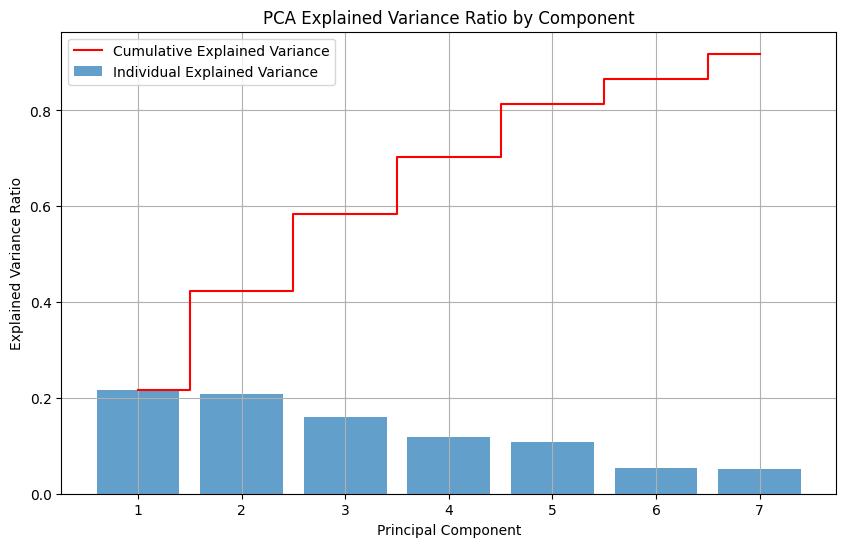

In [108]:
# plot the explained variance ratio for each principal component
clusterer.plot_pca_explained_variance()

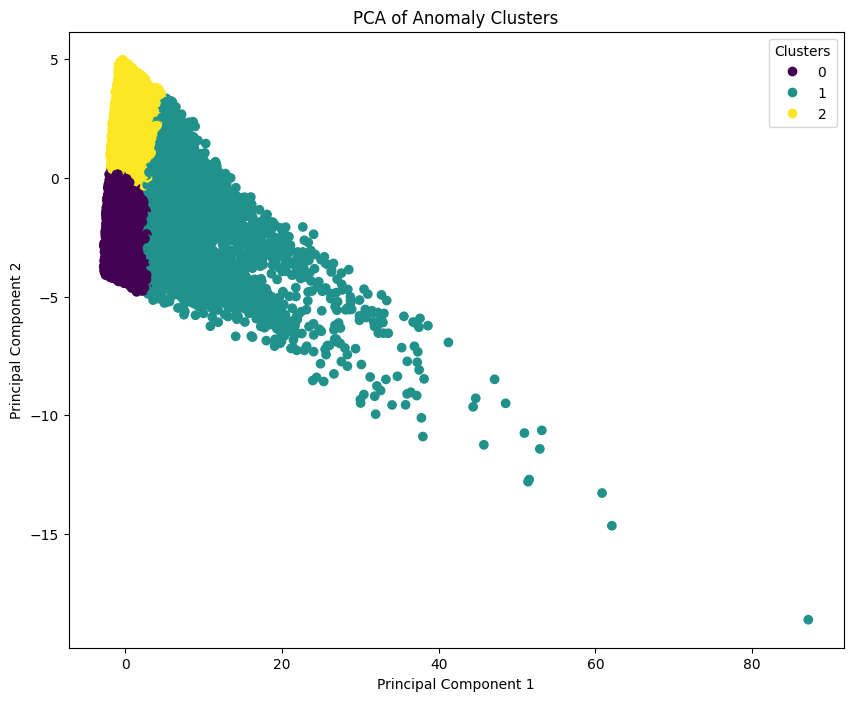

In [109]:
# Visualize the clusters in a two-dimensional space using first two principal components
clusterer.visualize_clusters()

## 5.11 Feature Importance

Lasso regularization algorithm is used for to identify feature importance.

**Processing Features**

In [110]:
# Define features and target
features = Old_Anomalies_EngineeringFeatures_Clustered_df.drop(
    columns=[
        'MaxDepth_mm',
        'Tag',
        'ErrorClassification',
        'DepthChange'
    ]
)

target = Old_Anomalies_EngineeringFeatures_Clustered_df['MaxDepth_mm']

Standardization of features is done.
Data splitting into training and testing sets is done.
Grid search is done. Best alpha value: 0.001
Fitting the Lasso model with the best alpha is done.
Calculation of feature coefficients is done.


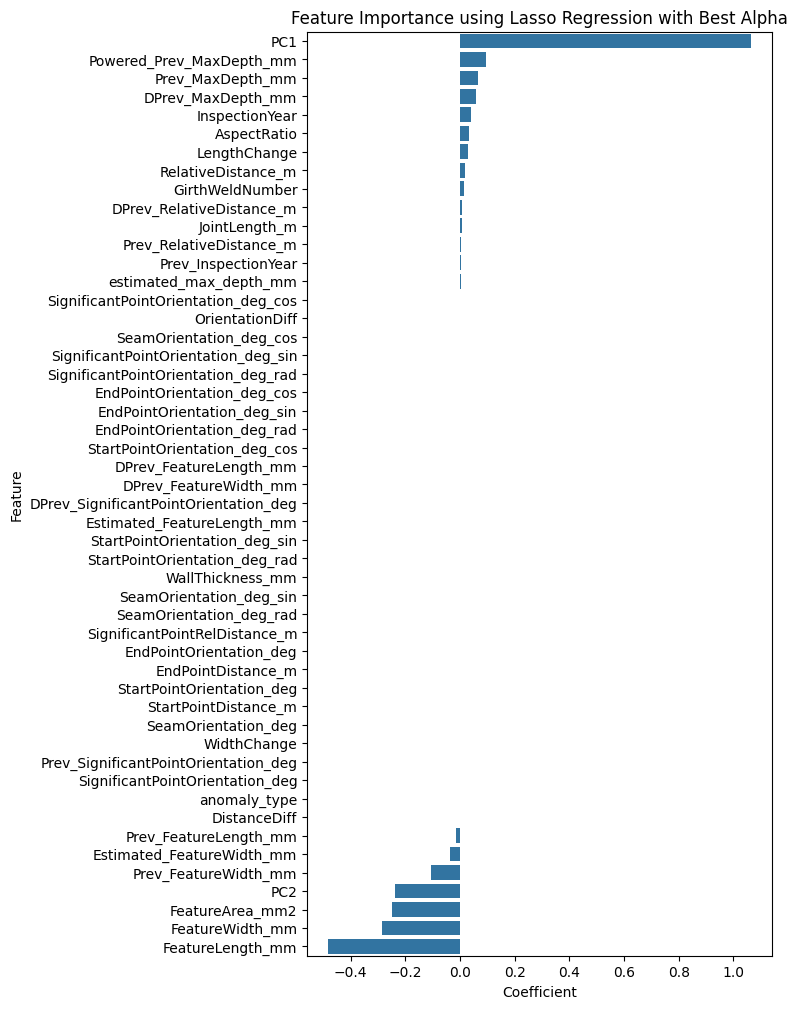

Plotting of coefficients is done.


In [111]:
from tools import FeatureImportance

feature_importance = FeatureImportance(features, target)

# Perform the steps
feature_importance.standardize_features()
feature_importance.split_data()
feature_importance.perform_grid_search()
feature_importance.fit_best_lasso()
feature_importance.calculate_coefficients()

# Plot the coefficients
feature_importance.plot_coefficients()

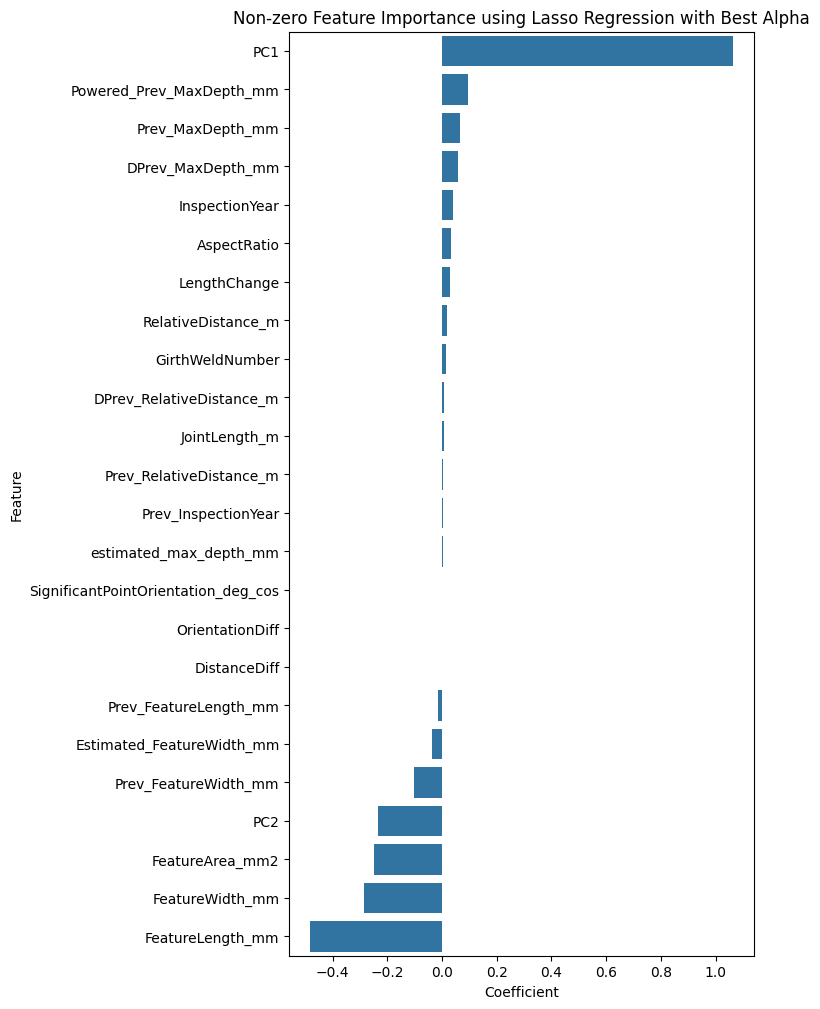

Plotting of non-zero coefficients is done.


In [112]:
# Plot non-zero coefficients
feature_importance.plot_non_zero_coefficients()

In [113]:
# Get the important features
importance_df = feature_importance.importance_df
important_features = importance_df[importance_df['Coefficient'].abs() > 0.01].Feature.tolist()
important_features

['PC1',
 'Powered_Prev_MaxDepth_mm',
 'Prev_MaxDepth_mm',
 'DPrev_MaxDepth_mm',
 'InspectionYear',
 'AspectRatio',
 'LengthChange',
 'RelativeDistance_m',
 'GirthWeldNumber',
 'Prev_FeatureLength_mm',
 'Estimated_FeatureWidth_mm',
 'Prev_FeatureWidth_mm',
 'PC2',
 'FeatureArea_mm2',
 'FeatureWidth_mm',
 'FeatureLength_mm']

# 6. Training

## 6.1 Predicting Missing Values

### 6.1.1 Defining Features

In [114]:
Old_Anomalies_Training_df = Old_Anomalies_EngineeringFeatures_Clustered_df.copy()

In [115]:
# Define target variable
target = Old_Anomalies_Training_df['MaxDepth_mm']

# Define wall thickness variable
wt_mm = Old_Anomalies_EngineeringFeatures_Clustered_df.WallThickness_mm

# Keep all features, including rows where target is an outlier
features = Old_Anomalies_Training_df[important_features]

### 6.1.2 Training Pipeline and Evaluation

In [116]:
from tools import TrainingPipeline

# Create an instance of the TrainingPipeline class
ML_pipeline = TrainingPipeline(features, target)
print("Pipeline instance created")

# Scale the features
ML_pipeline.scale_features()
print("Features scaled")

# Split the data
ML_pipeline.split_data(handle_imbalance=True)
print("Data split")

# Perform hyperparameter tuning and return the best parameters
best_params = ML_pipeline.hyperparameter_tuning()
print("Best parameters found:")
print(best_params)

# Fit the model using the best hyper parameters
best_model = ML_pipeline.fit_model()
print("Model fitted")

Pipeline instance created
Features scaled
Data split
Best parameters found:
OrderedDict([('l2_regularization', 0.01), ('learning_rate', 0.050490865599649756), ('max_depth', 3), ('max_iter', 100), ('min_samples_leaf', 5)])
Model fitted


In [117]:
# Evaluate the model and print the metrics across minority class
ML_pipeline.evaluate_model()

{'RMSE': 0.2699, 'MAE': 0.2251, 'R2': 0.9245, 'MAPE': 25.5247, 'ME': -0.0242}

```python
# Previous performance metrics
{'RMSE': 0.2699, 'MAE': 0.2251, 'R2': 0.9245, 'MAPE': 25.5247, 'ME': -0.0242}



### 6.1.3 Imbalance Distribution Analysis

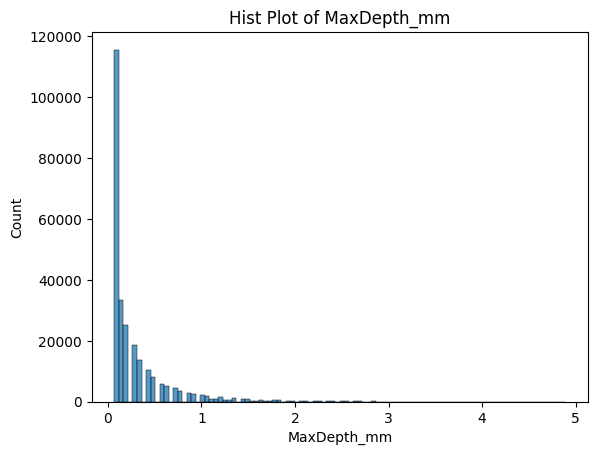

In [118]:
# class_counts = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm'].value_counts().sort_index()
sns.histplot(Old_Anomalies_Training_df['MaxDepth_mm'], bins=100)
plt.title('Hist Plot of MaxDepth_mm')
plt.xlabel('MaxDepth_mm')
plt.ylabel('Count')
plt.show()

### 6.1.4 Model Performance Visualization

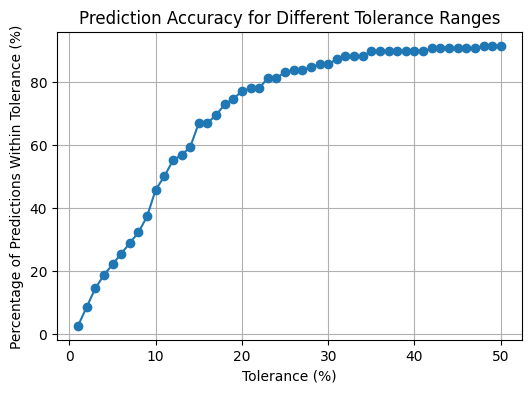

In [119]:
# Plotting results and evaluating prediction accuracy
results = ML_pipeline.plot_prediction_accuracy()

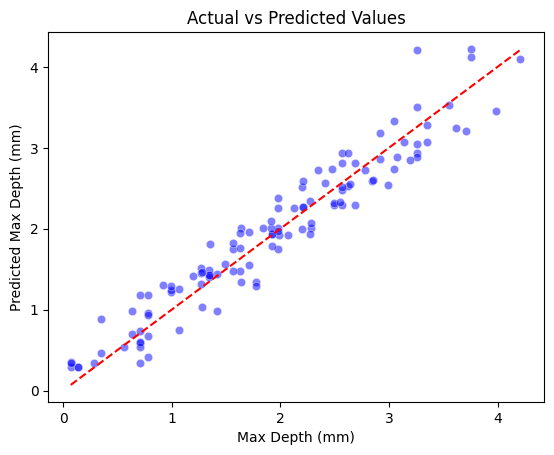

In [120]:
ML_pipeline.plot_scatter(results)

## 6.2 Anomaly Growth

### 6.2.1 Training and Evaluation Pipeline

In [121]:
# Apply the mask to remove outliers only from the target variable
target = Old_Anomalies_Training_df['MaxDepth_mm']

# Define the list of features
feature_columns = [
        'GirthWeldNumber',
        'InspectionYear',
        'RelativeDistance_m',
        'Estimated_FeatureLength_mm',
        'Estimated_FeatureWidth_mm',
        'SignificantPointOrientation_deg',
        'Prev_InspectionYear',
        'Prev_RelativeDistance_m',
        'Prev_FeatureLength_mm',
        'Prev_FeatureWidth_mm',
        'Prev_MaxDepth_mm',
        'Powered_Prev_MaxDepth_mm',
        'Prev_SignificantPointOrientation_deg',
        'DPrev_RelativeDistance_m',
        'DPrev_FeatureLength_mm',
        'DPrev_FeatureWidth_mm',
        'DPrev_MaxDepth_mm',
        'DPrev_SignificantPointOrientation_deg',
        'SignificantPointOrientation_deg_sin',
        'SignificantPointOrientation_deg_cos'
    ]

# Keep all features, including rows where target is an outlier
features = Old_Anomalies_Training_df[feature_columns]

# Ensure features and target have the same index
features = features.loc[target.index]

In [122]:
from tools import TrainingPipeline

# Create an instance of the TrainingPipeline class
ML_pipeline = TrainingPipeline(features, target)
print("Pipeline instance created")

# Scale the features
ML_pipeline.scale_features()
print("Features scaled")

# Split the data
ML_pipeline.split_data(handle_imbalance=True)
print("Data split")

# Perform hyperparameter tuning and return the best parameters
best_params = ML_pipeline.hyperparameter_tuning()
print("Best parameters found:")
print(best_params)

# Fit the model using the best hyper parameters
best_model = ML_pipeline.fit_model()
print("Model fitted")

# Evaluate the model and print the metrics
evaluation_metrics = ML_pipeline.evaluate_model()
for metrics,performance in evaluation_metrics.items():
    print(f"{metrics}: {performance}")

Pipeline instance created
Features scaled
Data split
Best parameters found:
OrderedDict([('l2_regularization', 0.01), ('learning_rate', 0.01), ('max_depth', 3), ('max_iter', 458), ('min_samples_leaf', 5)])
Model fitted
RMSE: 0.2787
MAE: 0.2339
R2: 0.9123
MAPE: 29.5475
ME: 0.0094


### 6.2.2 Visualizing Model Performance

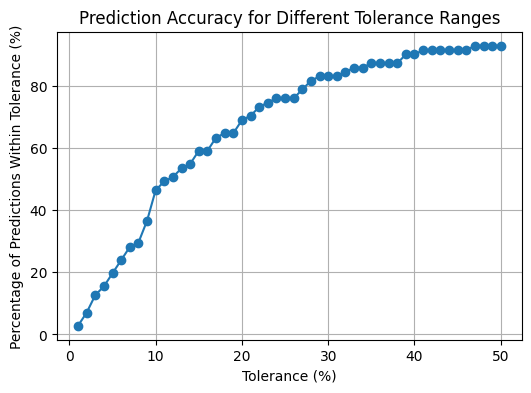

In [123]:
results = ML_pipeline.plot_prediction_accuracy()

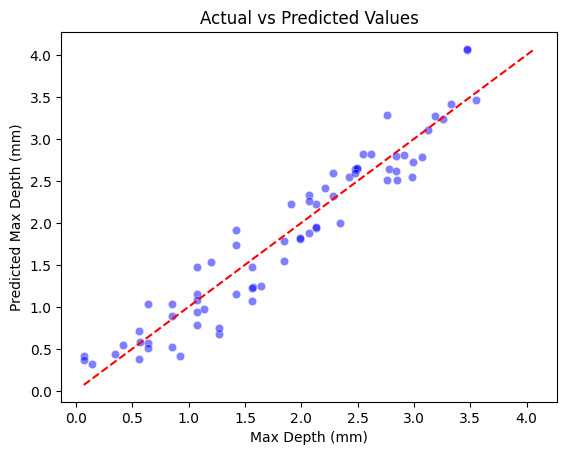

In [124]:
ML_pipeline.plot_scatter(results)

### 6.2.3 Predicting Future Max Depth

Data preparation is done.
Predictions are done.

Top 10 Anomalies with Most Predicted Depth:
        GirthWeldNumber  MaxDepth_mm  Prediction_MaxDepth_mm  WallThickness_mm
622108           3601.0         4.89                4.890000               7.1
438553          16387.0         4.40                4.400000               7.1
281173          13742.0         4.18                4.180000               7.1
261155          13465.0         3.97                4.054671               7.1
795827           7112.0         4.04                4.040000               7.1
458258          17121.0         3.97                4.028603               7.1
260888          13464.0         3.90                3.900000               7.1
731576           5575.0         3.76                3.760000               7.1
809192           7283.0         3.76                3.760000               7.1
92152           11706.0         3.62                3.620000               7.1

Top 10 Joints with Highest Sum of Pre

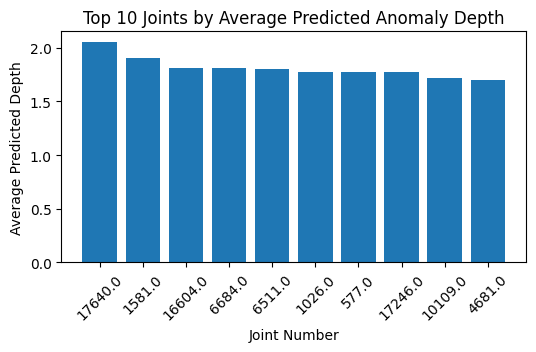

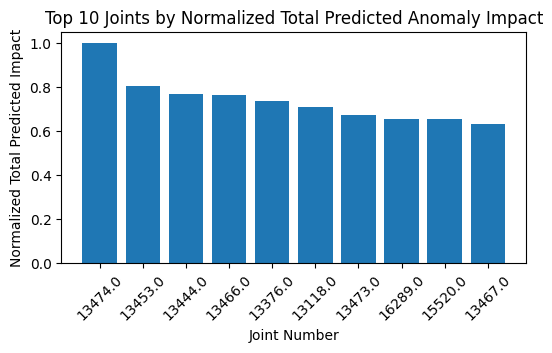

Analytics are done.


In [125]:
from tools import AnomalyPredictionPipeline

Old_Anomalies_Prediction_df = Old_Anomalies_Training_df.copy()
Old_Anomalies_Prediction_df['WallThickness_mm'] = wt_mm

prev_inspection_year = 7
next_inspection_year = 9

# Create an instance of the pipeline
pipeline = AnomalyPredictionPipeline(model=best_model, df= Old_Anomalies_Prediction_df, prev_inspection_year=7, next_inspection_year=9)

# Prepare data
Old_Anomalies_Prediction_df = pipeline.prepare_data(wt_mm, feature_columns, target.name)

# Make predictions
Old_Anomalies_Prediction_df = pipeline.make_predictions( feature_columns)

# Perform analytics
pipeline.perform_analytics((6, 3))